# Question 1

In this question we will
- Implement the vector grandient operators for colour images.
- Implement the kurtosis measure of image blur/sharpness which is caluclated from image gradients and assess whether it is a reasonable metric of blur.
- Learn to create blur maps of images to visualize the amount of blur in local image patches.



# Step 1: Implement the vector gradient.

Implement the vector gradient as described in the lecture slides in the `color_sobel_edges()` function below.  Use Sobel filters to estimate partial derivatives.  Use the `color_dot_product()` function (provided) to compute the necessary dot products to obtain gxx, gyy, and gxy.  Return an array containing the gradient magnitudes for each pixel, i.e. a graident magnitude image.  Optionally, return a second array containing the gradient directions for each pixel.

The input image must be dtype `float` or `uint8`.  If it is `uint8` convert it to `float` before processing.  Leave the magnitude image ouput as dtype `float` regardless of the input's dtype.

In [1]:
import skimage.util as util
import numpy as np
from skimage.filters import sobel_h, sobel_v


def color_dot_product(A, B):
    '''
    Element-by-element dot product in a 2D array of vectors.

    :return: An array in which index [i,j] is the dot product of A[i,j,:] and B[i,j,:].
    '''
    return np.sum(A.conj()*B, axis=2)



def color_sobel_edges(I, direction = False):
    '''
    Finish me!
    
    :param I: input colour image
    :return: numpy array containing gradient magnitudes for each pixel
    '''

    if I.dtype != np.float64:
        I = util.img_as_float(I)


    Gx = np.stack([sobel_h(I[:,:,c]) for c in range(3)], axis=2)
    Gy = np.stack([sobel_v(I[:,:,c]) for c in range(3)], axis=2)

    Gxx = color_dot_product(Gx, Gx)
    Gyy = color_dot_product(Gy, Gy)
    Gxy = color_dot_product(Gx, Gy)

    theta = 0.5*np.arctan2(2*Gxy, Gxx-Gyy)
    mag = np.sqrt(0.5*((Gxx+Gyy)+(Gxx-Gyy)*np.cos(2*theta))+2*Gxy*np.sin(2*theta))

    if direction:
        return mag, theta
    else:
        return mag

# Step 2: Examine behavior of the kurtosis sharpness metric.

Write a function which:

* takes as input an input image, a minimum value of sigma, and a maximum value of sigma.
* applies different amounts of Gaussian blur to the original image for integer values of sigma between the provided minimum and maximum values of sigma. (reminder: sigma describes the standard deviation of the gaussian filter mask used to blur the image).
    * Note: if using `skimage.filters.gaussian()`, you'll need to set the `channel_axis` parameter appropriately since you are applying it to a colour image.
* For each blurred image, compute the gradient magnitude using color_sobel_edges(), then compute compute the kurtosis sharpness measure.  This is *log(k+3)* where *k* is the kurtosis of the gradient magnitude image of the blurred image as described in the assignment description document.  See `scipy.stats.kurtosis()`.
* Return a tuple consisting of the range object of sigma values used and the list of computed kurtosis values for each sigma.

Then:
* Call the function using `mushroom.jpg` as the input image, a minimum sigma of 1, and a maximum sigma of 30.  Use a smaller max sigma until you are sure it's working, then increase to 30, as it can take a few minutes to do all the filtering.  Use the return values from your function to plot a line graph of gaussian blur sigma vs. blur measure (kurtosis) for the waterfall image.  Add appropriate axis labels and a descriptive title.  Sample output is provided in the assignment description document.



In [2]:
import scipy.stats as ss
from skimage.io import imread
from skimage.filters import gaussian

def test_blur_measure(I, min_sigma: int, max_sigma: int):
    '''
    Finish me!
    
    :param I: colour numpy array containing image
    :param min_sigma: minimum range of sigmas to apply gaussian blur to image
    :param max_sigma: maximum range of sigmas to apply gaussian blur to image
    :return: tuple of range of sigmas applied to I and a list of kurtosis values for each sigma in the range
    '''

    if min_sigma > max_sigma:
        raise ValueError("min_sigma must be less than or equal to max_sigma")
    
    sigmas = range(int(min_sigma), int(max_sigma)+1)
    vals = []
    for s in sigmas:
        noisy = gaussian(I, sigma = s, channel_axis = 2)
        sobelled = color_sobel_edges(noisy)
        val = np.log(ss.kurtosis(sobelled.ravel(), fisher=False))
        vals.append(val)

    return (sigmas, vals)

        
image = imread("mushroom.jpg")
results = test_blur_measure(image, 1, 30)

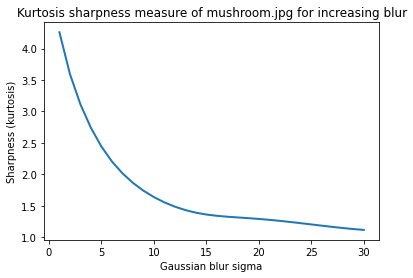

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(list(results[0]), results[1], lw=2)
plt.xlabel("Gaussian blur sigma")
plt.ylabel("Sharpness (kurtosis)")
plt.title("Kurtosis sharpness measure of mushroom.jpg for increasing blur")
plt.grid(False)
plt.show()

# Step 3:  Create a local blur map

Write a function which:

* takes as input an image and a window size (in pixels).
* computes the local sharpness of the input image (i.e. log(kurtosis+3)) for each tiled, non-overlapping square window of the given window size
* stores each local sharpness in an array where each entry represents one window of the input image (the size of this array can be computed by integer division of the original image dimensions by the window size)
* returns the array of local sharpnesses.

Then:

- call the function you just wrote with `mushroom.jpg` as the input image and 100 as the window size.  
- Plot the returned array as an image using `plt.imshow()`.  Do not rescale this image with `vmin=` or `vmax=`, and use the default colormap (don't change it to `'gray'`).  
- Add a color scale bar using `plt.colorbar()`.  Sample output is provided in the assignment description document.



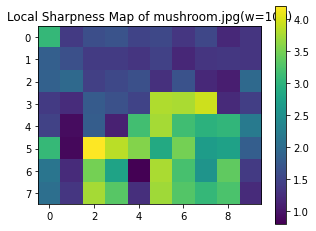

In [4]:
def sharpness_map(I, window_size):
    if I.dtype == np.uint8:
        I = util.img_as_float(I)

    H, W, _ = I.shape
    ws = int(window_size)
    Hr = H // ws
    Wr = W // ws
    M = np.zeros((Hr, Wr), dtype=float)

    for r in range(Hr):
        for c in range(Wr):
            tile = I[r*ws:(r+1)*ws, c*ws:(c+1)*ws, :]
            mag = color_sobel_edges(tile)
            k = ss.kurtosis(mag.ravel(), fisher=False)
            M[r, c] = np.log(k)
    return M

sharpness = 100
S = sharpness_map(image, sharpness)
plt.figure(figsize=(5,4))
plt.imshow(S)
plt.title(f"Local Sharpness Map of mushroom.jpg(w={sharpness})")
plt.colorbar()
plt.show()


# Step 4: Try it on another image.

Use the functions you wrote to produce the same plots as in steps 2 and 3 but for the `waterfall.jpg` image instead.


In [5]:
I_w = imread("waterfall.jpg")

waterfall_results = test_blur_measure(I_w, 1, 30)

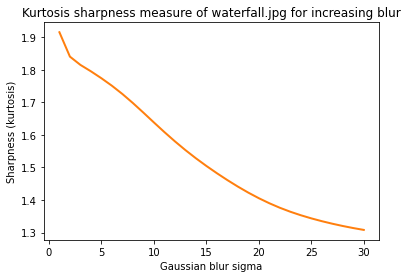

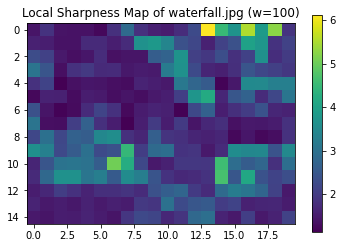

C:\Users\predi\AppData\Local\Temp\ipykernel_10752\34512203.py:16: RuntimeWarning: divide by zero encountered in log
  M[r, c] = np.log(k)


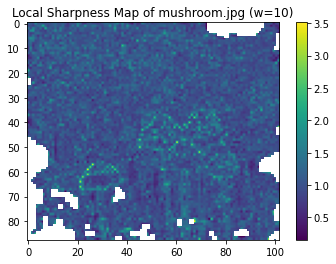

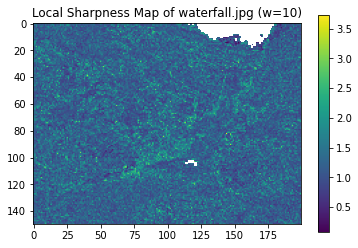

In [6]:
plt.figure(figsize=(6,4))
plt.plot(list(waterfall_results[0]), waterfall_results[1], lw=2, color='tab:orange')
plt.xlabel("Gaussian blur sigma")
plt.ylabel("Sharpness (kurtosis)")
plt.title("Kurtosis sharpness measure of waterfall.jpg for increasing blur")
plt.grid(False)
plt.show()

S_w = sharpness_map(I_w, 100)
plt.figure(figsize=(6,4))
plt.imshow(S_w)
plt.title("Local Sharpness Map of waterfall.jpg (w=100)")
plt.colorbar()
plt.show()

S_m10 = sharpness_map(image, 10)
plt.figure(figsize=(6,4))
plt.imshow(S_m10)
plt.title("Local Sharpness Map of mushroom.jpg (w=10)")
plt.colorbar()
plt.show()

S_w10 = sharpness_map(I_w, 10)
plt.figure(figsize=(6,4))
plt.imshow(S_w10)
plt.title("Local Sharpness Map of waterfall.jpg (w=10)")
plt.colorbar()
plt.show()

# Step 5: Thinking and Qualitative Analysis

### Answer the following questions, right here in this block.

1. Based on your observations of the previous results (you can try it on additional images if you wish), discuss the advantages and disadvantages of the kurtosis-based measure of image sharpness, citing specific evidence observed to justify your claims.

	* Pros: Seems quite fast. Even though I was warned that it would take a few minutes to test the 1-30 sigma range, it only took ~15 seconds on mushroom and ~45 on waterfall. Seems like it would be a good way to threshold for sharpness if you were looking for a cutoff between "sharp" and "not sharp" quickly.

	* Cons: Kurtosis seems sensitive to outliers, very tiny windows were yield unstable values. Both mushroom and waterfall have spots where the function seems to have divided by 0 when the window size was 10. In waterfall, the image was in focus the whole time, but naturally low-contrast, which results in a basically unreadable sharpness map.
    
2. Think of what the shape of a histogram of gradient magnitudes would look like for a sharp image.  Why does this set of gradient magnitudes have high kurtosis?  (It might help to look up kurtosis and see what it measures about a histogram!)

	* Having a sharp image would mean a relatively large number of high gradient magnitudes, since sharp lines in the image would create quick changes in the derivatives. However, most pixels will still fall in a "smooth" region of the image, like the mushroom's heads and stems in mushroom.jpg. This means we would have a histogram with a big spike in the low values (probably near zero) and a thick tail running into the high values. 

	* Kurtosis measures the 4th moment, which is described as the "tailedness" or "heaviness" of a histograms tail relative to its center. Since our center would be low (near zero) and we have a think tail that extends far from our center, we would expect a high kurtosis value.

3. Now think what would happen as that same image gets blurrier.  Explain how the shape of the histogram would change, and the corresponding effect on the kurtosis.

	* As we blur the image, the sharp lines would be blended into their surroundings, resulting in less large gradient magnitudes in the histogram and more points in the peak. This in turn would mean the "tailedness" of our graph would decrease, which is equivalent to our kurtosis decreasing. This is evident in both the sharpness vs blur plots we made, as blurring the image more made the sharpness lower, and sharpness is directly related to kurtosis